In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib ipympl

In [252]:
class SingleProbe:
    def __init__(self, probe_time, wait_time, sample_rate=25e6, total_time=0.01, frequency=0):
        self._probe_time = probe_time
        self._wait_time = wait_time
        self._total_time = total_time
        self._sample_rate = sample_rate
        self._frequency = frequency

    def time_domain_data(self):
        if self._frequency > 0:
            times = np.arange(int(self._probe_time * self._sample_rate)) / self._sample_rate
            probe_ones = np.sin(2 * np.pi * self._frequency * times) * np.sqrt(2) / np.sqrt(self._probe_time)
        else:
            probe_ones = np.ones(int(self._probe_time * self._sample_rate)) / np.sqrt(self._probe_time)
        wait_zeros = np.zeros(int(self._wait_time * self._sample_rate))
        probe_minus_ones = -probe_ones
        total_zeros = np.zeros(int((self._total_time - self._wait_time - self._probe_time * 2) * self._sample_rate))
        data = np.append(np.append(np.append(probe_ones, wait_zeros), probe_minus_ones), total_zeros)
        times = np.arange(len(data)) / self._sample_rate
        return (times, data)

    def frequency_sensitivity(self):
        times, data = self.time_domain_data()
        freqs = np.fft.rfftfreq(len(data), times[1] - times[0])
        amplitudes = np.abs(np.fft.rfft(data)) / self._sample_rate
        return (freqs, amplitudes)

1.0000000000000002
1.0000000000000004


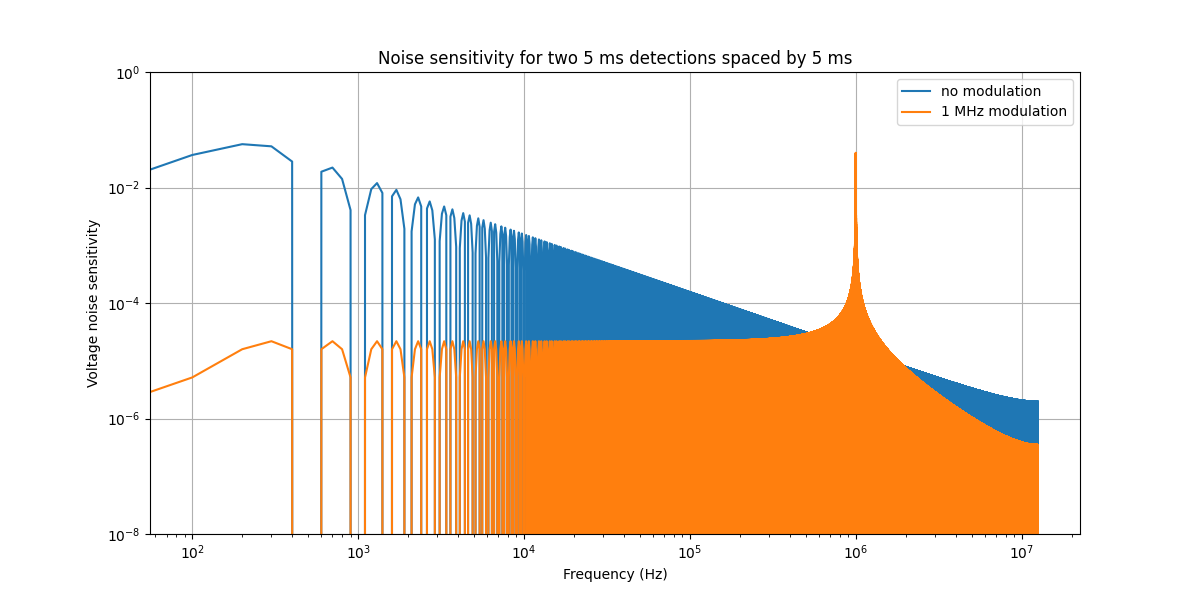

In [253]:
fig, ax = plt.subplots(figsize=(12, 6))
sp = SingleProbe(1e-3, 1e-3)
freqs, amplitudes = sp.frequency_sensitivity()
print(np.sum(amplitudes**2) * (freqs[1] - freqs[0]))
ax.plot(freqs, amplitudes, label="no modulation")
sp = SingleProbe(1e-3, 1e-3, frequency=1e6)
freqs, amplitudes = sp.frequency_sensitivity()
print(np.sum(amplitudes**2) * (freqs[1] - freqs[0]))
ax.plot(freqs, amplitudes, label="1 MHz modulation")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Voltage noise sensitivity")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Noise sensitivity for two 5 ms detections spaced by 5 ms")
ax.set_ylim(1e-8, 1)
ax.legend()
ax.grid()
plt.show()

In [82]:
t_on = 10e-6 / 1
t_off = 2e-6 / 1
N_mu = 2
t_total = (t_on + t_off) * N_mu
N = 1

sample_rate = 25e6
N_step = int(t_total * sample_rate)
ts = np.arange(0, N_step * N) / sample_rate
phases = np.linspace(0, 2 * np.pi, 20)

In [17]:
def voltage_sine(f, phase=0):
    return np.sin(2 * np.pi * f * ts + phase) * np.sqrt(2)

In [18]:
def data_points(f, phase):
    N_step = int(t_total * sample_rate)
    V = voltage_sine(f, phase).reshape(N, N_step)
    dps = []
    for kk in range(N_mu):
        start = int(kk * (t_on + t_off) * sample_rate)
        end = int((kk * (t_on + t_off) + t_on) * sample_rate)
        dp = np.average(V[:, start:end])
        dps.append(dp)
    return dps

In [19]:
stds = []
fs = np.logspace(0, 8, 1000)
for f in fs:
    std_f = []
    for phase in phases:
        std_f.append(np.std(data_points(f, phase)))
    stds.append(np.average(std_f))
stds = np.array(stds)

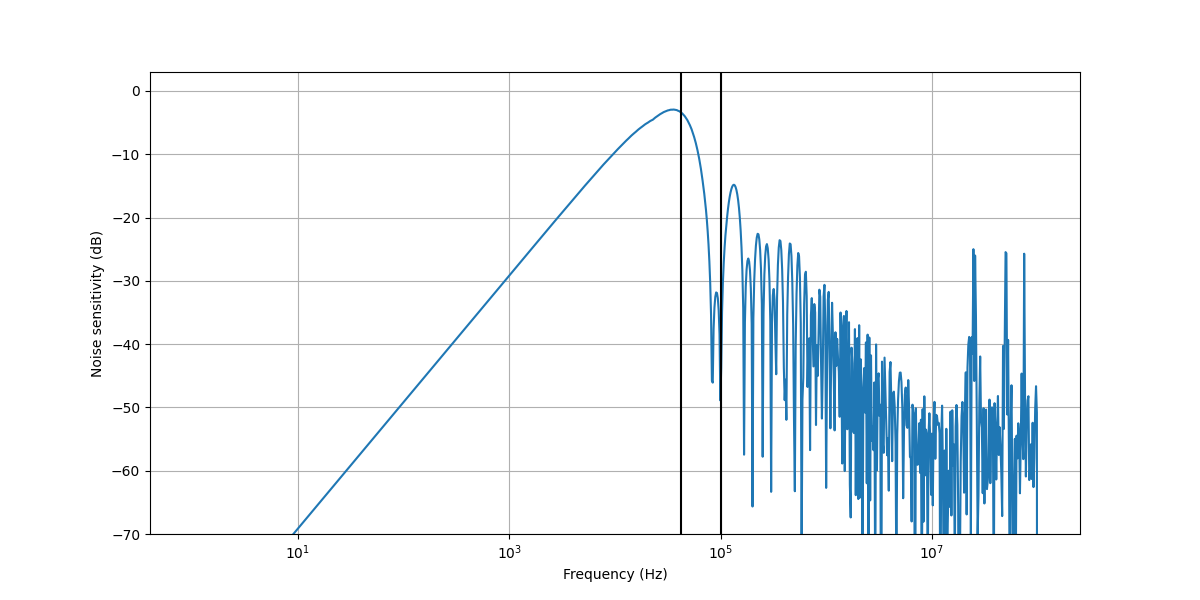

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(fs, np.log10(stds ** 2) * 10)
ax.set_xscale("log")
ylim_low, ylim_high = ax.get_ylim()
ax.vlines([1 / t_on, 1 / t_total], ylim_low, ylim_high, color="k")
ax.set_ylim(np.max([ylim_low, -70]), 3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Noise sensitivity (dB)")
ax.grid()
plt.show()